# Оценочные метрики для задач классификации

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Достоверность классификации - процент правильных прогнозов, которые дает модель.
Находится как отношение правильно-спрогнозированных прогнозов ко всем

In [2]:
# Вычисляем достоверность:
# y_pred = model.predict_proba(x_val)[:, 1]
# churn = y_pred >= 0.5
# (churn == y_val).mean()

## Попробуем заново переобучить модель из 3 главы

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [6]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [7]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [8]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [10]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [11]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

# Метрики оценки:

## Accuracy - процент (или доля) случаев, классифицированных правильно

In [12]:
y_pred = model.predict_proba(X_val)[:, 1]  # получает прогнозы из модели
churn = y_pred >= 0.5  # Делает "твердые" прогнозы
(churn == y_val).mean().item()  # Вычисляет достоверность модели

0.8016129032258065

можно реализовать с помощью sklearnn

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

Теперь мы можем перебрать различные пороговые значения, и выяснить, какие из них дают лучшую достоверность:

In [15]:
# создаем и выводим массив от 0 до 1 с шагом 0.1
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [16]:
thresholds = np.linspace(0, 1, 21) # создаем и выводим массив от 0 до 1 с шагом 0.05

accuracies = []

for t in thresholds: # циклы по каждому пороговому значению
    acc = accuracy_score(y_val, y_pred >= t) # использует ф-цию accuracy для заданного порога
    accuracies.append(acc) # записываем достоверность этого порога
    print('%0.2f %0.3f' % (t, acc)) # выводит пороговые значения и значения достоверности в стандартный вывод

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


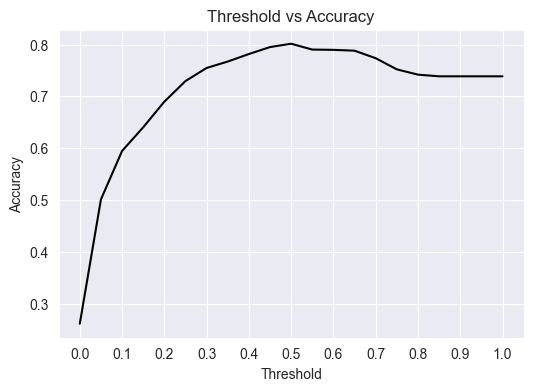

In [17]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

лучшая достоверность на пороге 0.5

In [18]:
# Найдем достоверность малой модели:

churn_small = y_pred_small >= 0.5
(churn_small == y_val).mean().item()

0.7672043010752688

In [19]:
accuracy_score(y_val, churn_small)

0.7672043010752688

### Фиктивная базовая линия:

Базовая линия - это "модель", которая всегда прогнозирует одинаковое значение для всех клиентов.

In [20]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [21]:
accuracy_score(baseline, y_val)

0.7387096774193549

Достоверность фиктивной модели 0.73. Наша малая модель лучше этой всего на 2%, а большая - на 6%

## Confusion table

Истинно отрицательный (TN) - мы предсказываем False ("без оттока"), и фактическая метка тоже False ("без оттока)

Истинно положительный (TP) - мы прогнозируем True ("отток"), и фактическая метка тоже True ("Отток")

Ложноотрицательный (FN) - мы прогнозируем False ("без оттока"), но на самом деле это True (клиент ушел)

Ложноположительный (FP) - мы прогнозируем True ("отток"), но на самом деле это False (клиент остался с нами)

In [22]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [23]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [24]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

## Precision and recall

Точность (precision) - каков процент правильных прогнозов TP среди клиентов с прогнозом "отток" (TP + FP)

Отклик (recall) - каков процент правильных прогнозов "оттока" (TP) среди всех клиентов с "оттоком" (TP + FN)

In [25]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision.item(), recall.item()

(0.6268980477223427, 0.5946502057613169)

Точность 62% означает, что 62% охваченных клиенто действительно собирались отказаться, в то время как 38% - нет

Отклик 59% означает, что мы охватываем только 59% всех пользователей, которые планируют уйти, и не в силах обнаружить остальные 41%

## Кривая ROC и оценка AUC

### TPR and FPR

In [26]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:   # Bычисляем марицу ошибок
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores) # превращаем список в датафрейм Pandas
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [27]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [28]:
# вычисляем tpr и fpr

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

FPR - доля ложноположительных результатов среди всех отрицательных
FPR = FP / (FP + TN)

TPR - доля истинно положительных результатов среди всех положительных примеров
TPR = TP / (TP + FN)

In [29]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


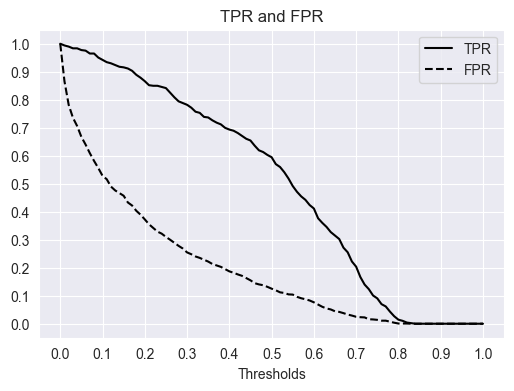

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

В идеале FPR должен снижаться очень быстро. Небольшой FPR указывает на то, то модель допускает очень мало ошибок, прогнозируя отрицательные примеры (ложноположительные результаты)

С другой стороны, TPR должен снижаться медленно, в идеале оставаясь все время около 100% : это будет означать, что модель хорошо прогнозирует истинноположительные результаты.

### Случайная базовая модель:

In [31]:
# Функция вычисления TPR и FPR при различных пороговых значениях

def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [32]:
# Используем эту функцию для вычисления TPR и FPR случайной модели:

np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


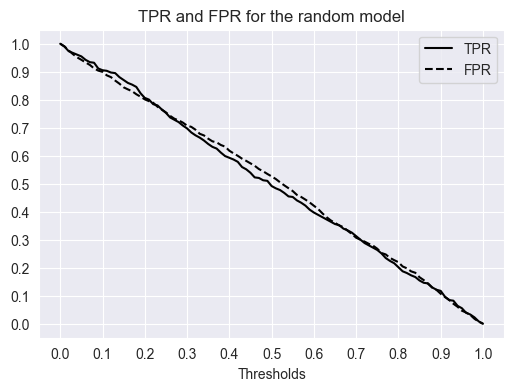

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

При пороге 0.3 модель с вероятностью 30% дает прогноз "без оттока", а с вероятностью 70% прогнозирует отток. Как TPR , так и FPR   равны 70%:
    FPR составляет 70%, поскольку мы неправильно прогнозируем "отток" для 70% фактически оставшихся клиентов
    TPR составляет 70%, поскольку мы правильно классифицируем 70% ушедших клиентов как клиентов с "оттоком"
    

### Идеальная модель

In [34]:
# Вычисляем количество отрицательных и положительных примеров в наборе данных
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

# генерируем массив
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

#генерируем прогнозы модели
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

# Вычисляет кривые TPR и FPR для классификатора
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

# выводим
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


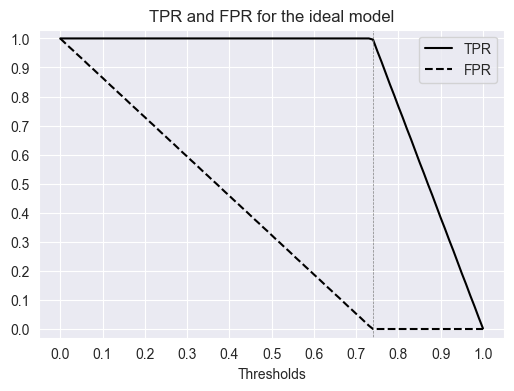

In [35]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

### ROC curve

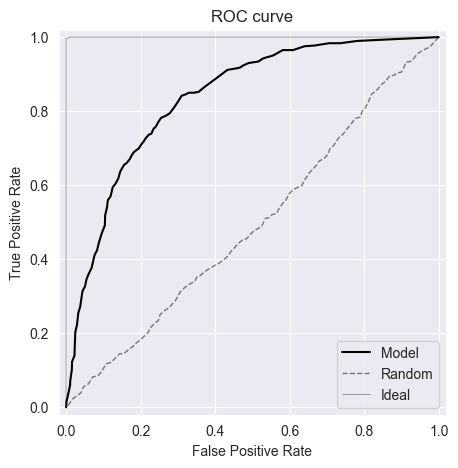

In [36]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

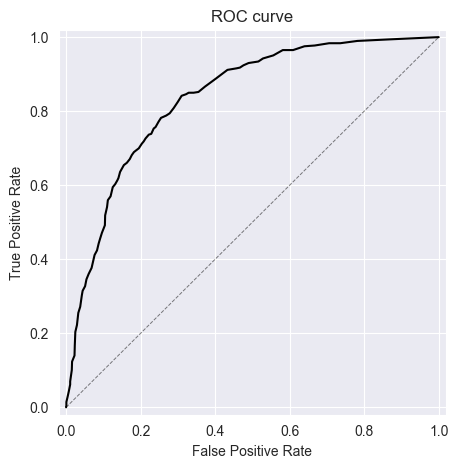

In [37]:
# Сокращаем код
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

### Испольование Scikit-Learn для построения кривой ROC

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [39]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

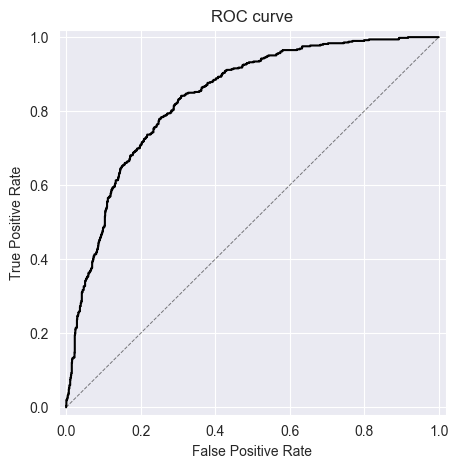

In [40]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

### Площадь под кривой ROC (AUC)

In [41]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [42]:
# AUC для большой модели
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8359001084215382)

In [43]:
# AUC для малой модели
auc(df_scores_small.fpr, df_scores_small.tpr)

np.float64(0.8108755488465984)

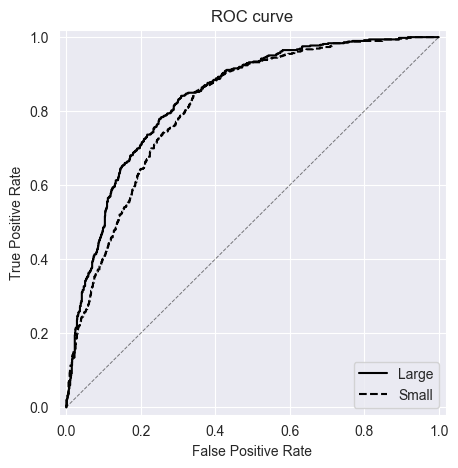

In [44]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
roc_auc_score(y_val, y_pred)

np.float64(0.8363366398907399)

In [47]:
roc_auc_score(y_val, y_pred_small)

np.float64(0.8117942866042492)

Интерпретация AUC: вероятность того, что случайно выбранный положительный пример получит более высокую оценку, чем случайно выбранный отрицательный

AUC так же описывает, насколько хорошо модель разделяет два класса

In [48]:
# Проверим это, повторив эксперимент 10000 раз. Затем подсчитаем, во сколько раз оценка положительного примера превышает оценку отрицательного. Когда это так, процент случаев, должен примерно соответствовать AUC

neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

np.float64(0.8356)

## Настройка параметров: к-кратная перекрестная проверка

In [49]:
#ОБУЧЕНИЕ МОДЕЛИ:
def train(df, y):
    # Применяем прямое кодирование:
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # Обучение модели:
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


In [50]:
# Применение модели к новым данным:
def predict(df, dv, model):
    # Применяем прямое кодирование:
    cat = df[categorical + numerical].to_dict(orient='records')
    
    # Обучение модели:
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [51]:
from sklearn.model_selection import KFold

In [52]:
# Использование KFOLD для разделения данных на 10 частей
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [53]:
aucs = [] # Создает список для хранения результатов

for train_idx, val_idx in kfold.split(df_train_full):
    # Разбиваем на проверочный и обучаюший набор даннных:
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values


    # Обучает модель и делает прогнозы:
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    # Оценивает качество модели с помощью auc
    rocauc = roc_auc_score(y_val, y_pred)
    
    # Сохраняет AUC в списке с результатами
    aucs.append(rocauc)

In [54]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.841, 0.844, 0.822, 0.845,
       0.861])

In [55]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


#### Поиск наилучших параметров (C)

In [56]:
# Добавляем параметр С
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # Используем параметр C для обучения модели:
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [57]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.4f ± %0.4f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.8250 ± 0.0131
C=0.01, auc = 0.8393 ± 0.0088
C=0.1, auc = 0.8411 ± 0.0079
C=0.5, auc = 0.8412 ± 0.0074
C=1, auc = 0.8412 ± 0.0074
C=10, auc = 0.8411 ± 0.0074


Выбираем c=0.5 поскольку небольшие веса модели, позволяют нам быть уверенными в том,  что модель будет вести себя должным образом, когда мы применим ее к реальным данным

In [58]:
# Обучаем модель на всех проверочных и обучающих наборах данных
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


После этого видимо, что производительность модели на удержанном тестовом наборе составляет 0.858